In [7]:
import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
from array import array
from sys import byteorder

FORMAT = pyaudio.paInt16 
CHANNELS = 1  
RATE = 16000 
CHUNK_SIZE = 1024 
WAVE_OUTPUT_FILENAME = "speech.wav"

# Buffer variables
SILENCE_THRESHOLD = 20  # number of continuous silent chunks to consider as the end of speech
silent_chunks = 0  # counter for silent chunks

p = pyaudio.PyAudio()

def EnergyPerSampleInDecibel(frame):
    data_int = array('h', frame)
    if byteorder == 'big':
        data_int.byteswap()
    energy = sum(abs(sample) for sample in data_int) / max(len(data_int), 1)
    energy = max(energy, 1e-7)  # Avoid log of zero
    decibels = 10 * np.log10(energy)
    return decibels

# Adaptive endpointing function
def classifyFrame(current, level, forgetfactor, adjustment, threshold, background):
    isSpeech = False
    level = ((level * forgetfactor) + current) / (forgetfactor + 1)
    
    if current < background:
        background = current
    else:
        background += (current - background) * adjustment
        
    if level < background:
        level = background
        
    if (level - background) > threshold:
        isSpeech = True
        
    return isSpeech, level, background

# Placeholder variables for the adaptive endpointing algorithm
forgetfactor = 1.0  
adjustment = 0.05  
threshold = 5  # In decibels
level = 0  # Initial level will be set by the first frame
background = 50  # Initially high to ensure speech is detected over it

print("Press Enter to start recording")
input()  

stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK_SIZE)

# Initialize recording loop
frames = []
isRecording = False  # Flag to start recording when speech is detected
print("Recording...")

while True:
    data = stream.read(CHUNK_SIZE, exception_on_overflow=False)
    current = EnergyPerSampleInDecibel(data)
    
    # Only start classifying after the first frame
    if level == 0:
        level = current
        background = current
    
    isSpeech, level, background = classifyFrame(current, level, forgetfactor, adjustment, threshold, background)
    
    if isSpeech:
        isRecording = True
        silent_chunks = 0  # reset the silent_chunks counter as we've detected speech
    else:
        if isRecording:
            # If we've started recording and encounter silence, increment the counter
            silent_chunks += 1
            # If we've hit the silence threshold, consider it the end of speech
            if silent_chunks > SILENCE_THRESHOLD:
                break
    
    if isRecording:
        frames.append(data)

print("Finished recording.")
    
stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

plt.style.use('dark_background')  

signal = np.frombuffer(b''.join(frames), dtype=np.int16)
plt.figure(figsize=(12, 4))
plt.plot(signal, color = 'cyan')
plt.title('Waveform of the Recorded Audio')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.savefig('waveform.png')
plt.show()


Press Enter to start recording


In [ ]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load the recorded audio file
audio, sample_rate = librosa.load(WAVE_OUTPUT_FILENAME, sr=None)

mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512, n_mels=40, fmin=133.33, fmax=6855.4976)

# Transpose the MFCCs to align the rows with time
mfccs = mfccs.T


NameError: name 'librosa' is not defined

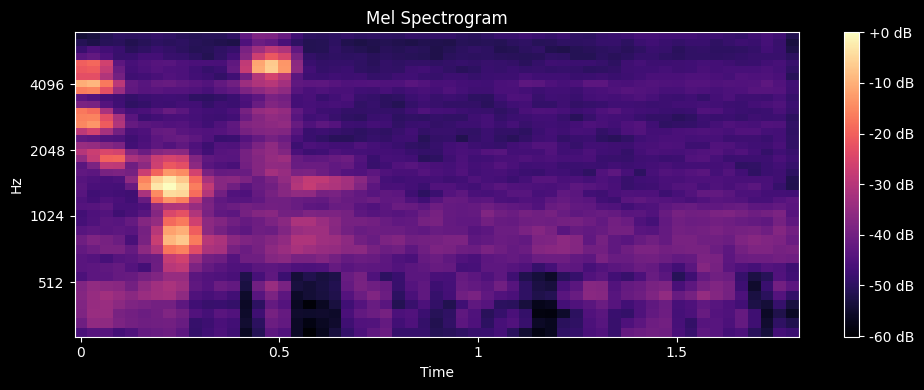

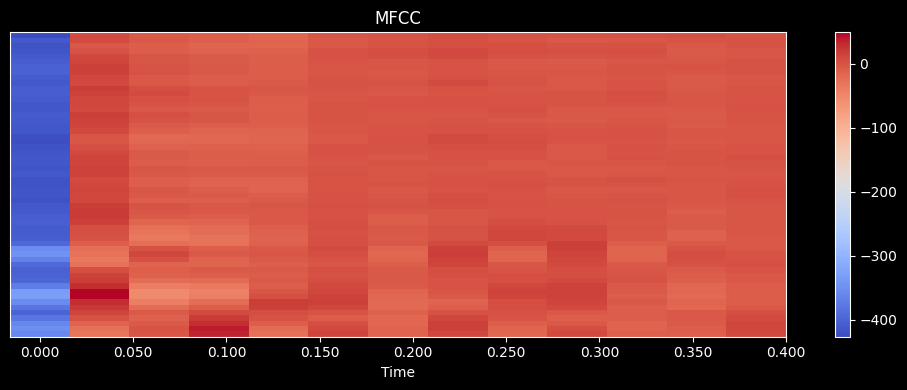

In [ ]:
# Visualize the Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=40, fmin=133.33, fmax=6855.4976), ref=np.max), sr=sample_rate, x_axis='time', y_axis='mel', fmin=133.33, fmax=6855.4976)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

# Visualize the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()


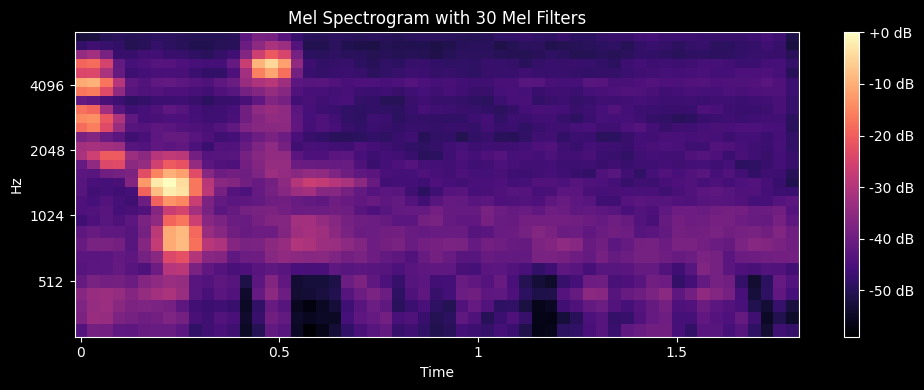

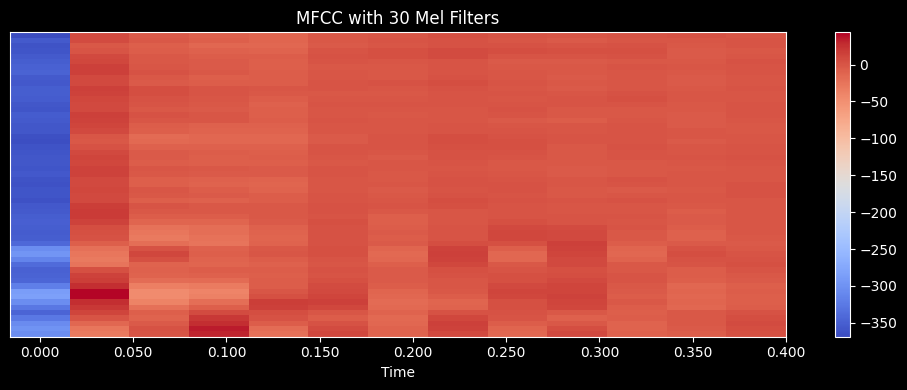

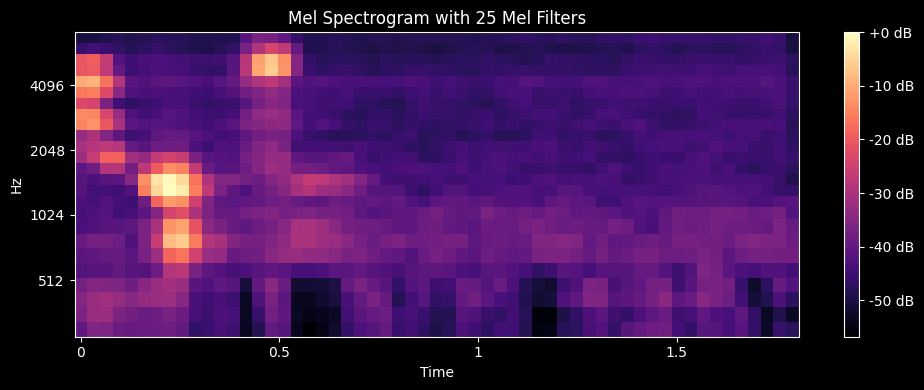

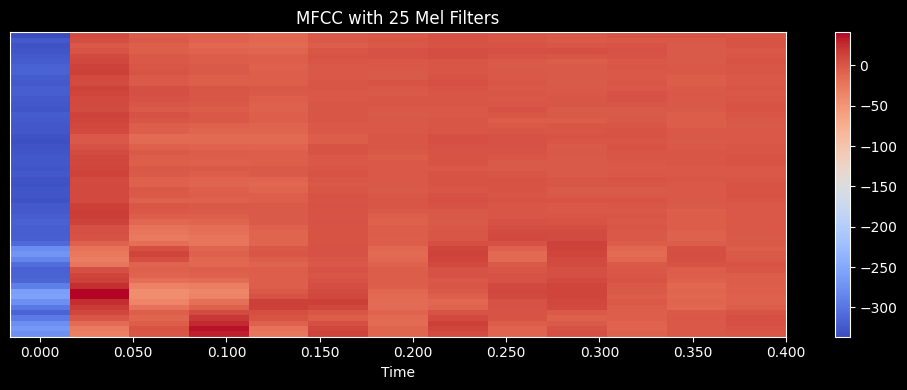

In [ ]:
# Function to compute and plot MFCCs and Mel Spectrogram
def compute_and_plot_mfccs(audio, sample_rate, n_mels):
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512, n_mels=n_mels, fmin=133.33, fmax=6855.4976)

    # Transpose the MFCCs to align the rows with time
    mfccs = mfccs.T

    # Plot Mel Spectrogram
    plt.figure(figsize=(10, 4))
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=n_mels, fmin=133.33, fmax=6855.4976)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sample_rate, x_axis='time', y_axis='mel', fmin=133.33, fmax=6855.4976)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram with {n_mels} Mel Filters')
    plt.tight_layout()
    plt.show()

    # Plot MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCC with {n_mels} Mel Filters')
    plt.tight_layout()
    plt.show()

# Now call the function with different numbers of Mel filters
compute_and_plot_mfccs(audio, sample_rate, n_mels=30)  # For 30 Mel filters
compute_and_plot_mfccs(audio, sample_rate, n_mels=25)  # For 25 Mel filters
